In [10]:
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None # supprime certains warnings
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MaxAbsScaler
import xgboost as xgb
import numpy as np

In [11]:

# X = pd.read_csv("../traitement_photos/X_avec_prix_et_images_complet_et_inflation.csv")
X = pd.read_csv("../Prix_metre/X_avec_prix_et_images_complet_et_inflation.csv")
X = X.drop(columns = ["gray_mean","quartile_inf","quartile_sup"])
y_train = pd.read_csv("../y_train_OXxrJt1.csv")
X_test = pd.read_csv("../Prix_metre/X_test_avec_prix.csv")
X_train = pd.read_csv("../Prix_metre/X_train_avec_prix.csv")

X.rename(columns = {'Prixm2_Moy':'Prix_2018','Prixm2' : 'Prix_2017'}, inplace = True)
annonces = X_test.id_annonce
y_train = y_train.drop(columns = ['id_annonce'])

## Feature Engineering

In [12]:
def features_incomplete(X):   
    Features_incomplete = []
    for x in X.columns:
        if X[x].isnull().sum()/len(X[x])*100 > 0:
            Features_incomplete.append(x)
    return Features_incomplete

def FE(X):
    X.drop(columns = ["exposition"],inplace=True)
    X.drop(columns=['ghg_category', 'energy_performance_category'], inplace=True)
    X['floor'].fillna(0, inplace=True)
    X['land_size'].fillna(0, inplace=True)

    #one hot encoding for property_type
    X = pd.get_dummies(X, columns=['property_type'], drop_first=False)

    # Label encoding for city
    le = LabelEncoder()
    X['city'] = le.fit_transform(X['city'])


    # Calcul des valeurs des départements plutôt que des codes postaux (en séparant les départements à 4 chiffres des départements à 5 chiffres)
    X["departement"]=X["postal_code"]
    X["departement"][X["departement"] < 10000]=X["departement"].astype(str).str[:1].astype(int)
    X["departement"][X["departement"] >= 10000]=X["departement"].astype(str).str[:2].astype(int)

    # Tentatives de remplir les valeurs manquantes de ces colonnes par la valeur moyenne pour le code postal associé
    #X["POPULATION_x"].fillna(X.groupby("postal_code")["POPULATION_x"].transform("mean"), inplace=True)
    #X["Nb_Transac"].fillna(X.groupby("postal_code")["Nb_Transac"].transform("mean"), inplace=True)
    #X["Nb_Ventes"].fillna(X.groupby("postal_code")["Nb_Ventes"].transform("mean"), inplace=True)
    
    X["nearly_price"]=X["PrixMoyen_M2"]*X["size"]
    X["nearly_price_1819"]=X["PrixMoyen_M2_1819"]*X["size"]
    X["prix_metre"] = np.sqrt(X["PrixMoyen_M2"])
    X["prix_metre_1819"] = np.sqrt(X["PrixMoyen_M2_1819"])
    # X["prix_metre_2017"] = np.sqrt(X["Prix_2017"])
    # X["prix_metre_2018"] = np.sqrt(X["Prix_2018"])
    # X["racine_size"] = np.sqrt(X["size"])
    # X["racine_land_size"] = np.sqrt(X["land_size"])
    
    X["Somme_bedrooms_rooms"] = X["nb_rooms"]+X["nb_bedrooms"]
    X["Somme_bathrooms_rooms"] = X["nb_rooms"]+X["nb_bathrooms"]
    X["Diff_bedrooms_bathrooms"] = X["nb_bathrooms"]-X["nb_bedrooms"]

  
    
    

    # Prendre l'entier de la longitude et de la latitude
    X["approximate_longitude"]=X["approximate_longitude"].astype(int)
    X["approximate_latitude"]=X["approximate_latitude"].astype(int)
    
    
    for x in ["approximate_longitude","approximate_latitude","nearly_price"]:
    # On remplit le reste par la valeur moyenne du département
        X[x].fillna(X.groupby("departement")[x].transform("mean"), inplace=True)
    


    
    X = X.drop(columns = ["id_annonce"],axis=1)

    scaler = MinMaxScaler()
    for x in X.columns:
        if X[x].dtype != 'object':
            X[x] = scaler.fit_transform(X[x].values.reshape(-1,1))

    # création d'un mini dataset avec les coordonnées et le prix pour pouvoir faire un clustering
    X_cluster_size = X[["approximate_longitude","approximate_latitude","nearly_price"]]

    N=15
    kmeans = KMeans(n_clusters=N)
    X_cluster_size["Cluster"] = kmeans.fit_predict(X_cluster_size)
    X_cluster_size["Cluster"] = X_cluster_size["Cluster"].astype("category")
    X["Cluster"]=X_cluster_size["Cluster"]

    scaler = MinMaxScaler()
    for x in X.columns:
       if X[x].dtype != 'object':
          X[x] = scaler.fit_transform(X[x].values.reshape(-1,1))

    return X

In [13]:
X = FE(X)

## Création d'un modèle de XGBoost

#### Modèle choisi

In [14]:
y_log_train = np.log1p(y_train)
y_log_train = y_log_train.reset_index(drop=True)


X_train = X.iloc[:len(X_train),:]
X_test = X.iloc[len(X_train):,:]

In [14]:
train_X, test_X, train_y, test_y = train_test_split(X_train, y_log_train, test_size=0.2, random_state=8)

my_kfold = KFold(n_splits = 5,shuffle = True)
features_improv = {"n_estimators" :[x for x in range(2000, 7000, 100)], "max_depth" : [x for x in range(1,15,1)], "learning_rate" : [x/100 for x in range(1,10,1)], "subsample" : [x/10 for x in range(1,10,1)], "colsample_bytree" : [x/10 for x in range(1,10,1)]}

xgbc = GridSearchCV(xgb.XGBRegressor(),param_grid=features_improv,cv=my_kfold,n_jobs=-1)
xgbc.fit(train_X,train_y)
print(xgbc.best_params_)

In [7]:
xgb_best = xgb.XGBRegressor(n_estimators=5000,max_depth = 9,learning_rate=0.08,colsample_bytree=0.5, subsample=0.9, n_jobs=-1)
xgb_best.fit(X_train,y_log_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.08, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=5000,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [8]:
from sklearn.metrics import mean_absolute_percentage_error
prediction = xgb_best.predict(X_train)
mean_absolute_percentage_error(y_train, np.expm1(prediction))*100

0.08400313304760477

#### Récup de la prédiction finale

In [9]:
prediction_y = xgb_best.predict(X_test)

Y_final = pd.DataFrame({"price" : np.expm1(prediction_y)})
Y_final.set_index(annonces, inplace=True)

Y_final.to_csv("y_pred_04_01.csv")

In [33]:
y_1 = pd.read_csv("C:/Users/maila/Documents/Centrale Nantes/EI2/INFOIA/STASC/Data_Challenge/STASC/Test_ML/y_pred_27_12_5.csv")

y_1.head()

,id_annonce,price
0,35160615,173982.90
1,35830639,986306.50
2,36016657,196440.67
3,35759225,253061.30
4,35252229,430512.30


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

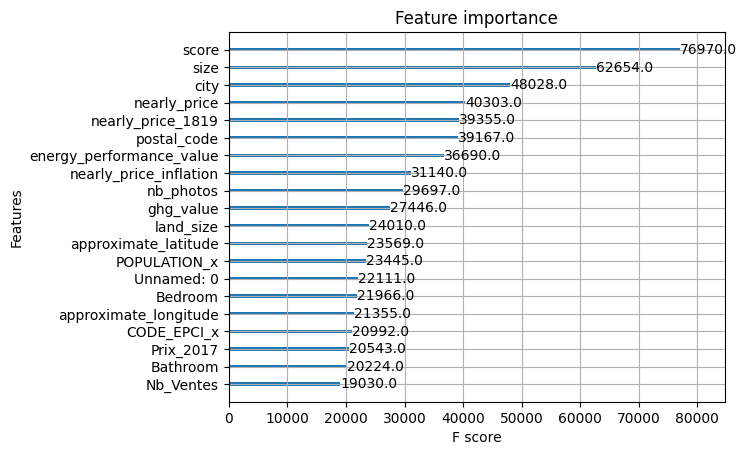

In [23]:
# Importance des features
xgb.plot_importance(xgb_best,max_num_features = 20)
    

> Qu'est ce que Unnamed: 0 ?

In [14]:
X[["energy_performance_value"]]

,Unnamed: 0
0,14319.0
1,4850.0
2,883.0
3,15741.0
4,34847.0
...,...
46702,34088.0
46703,NaN
46704,26881.0
46705,6679.0


> Test d'arrondissement des valeurs

In [9]:
y_a_arrondir = pd.read_csv("./y_pred_30_12_inflation_corrigee.csv")

In [10]:
# On arrondit les prix au millier le plus proche
y_a_arrondir["price"] = y_a_arrondir["price"].apply(lambda x : round(x,-3))

In [12]:
y_a_arrondir.head()

,id_annonce,price
0,35160615,193000.0
1,35830639,786000.0
2,36016657,209000.0
3,35759225,217000.0
4,35252229,445000.0


In [11]:
y_a_arrondir.to_csv("y_pred_30_12_inflation_corrigee_arrondi.csv",index=False)